In [ ]:
!pip install --quiet pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 49.6 MB/s eta 0:00:00


In [ ]:
!pip install -q pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx

import pgmpy, inspect
from pgmpy.estimators import HillClimbSearch, PC, GES, ExpertKnowledge
from pgmpy.inference import VariableElimination

print("pgmpy:", pgmpy.__version__)
print("HillClimbSearch.estimate signature OK?")
src = inspect.getsource(HillClimbSearch.estimate)
print("expert_knowledge" in src, "bic-d" in src or "bic" in src)


pgmpy: 1.0.0
HillClimbSearch.estimate signature OK?
True True


In [ ]:
# Colab-ready BN pipeline for Customer Churn (pgmpy 1.0.0)
# - Drops: RowNumber, CustomerId, Surname, Gender
# - Discretizes continuous vars (quantile KBins)
# - Enforces logical constraints via ExpertKnowledge
# - Trains 3 candidates: HC("bic-d"), PC(enforce EK)->HC refine, GES("bic-d")
# - Scores by 5-fold CV LogLoss & ROC-AUC on Exited

import io, numpy as np, pandas as pd, warnings, itertools
from typing import List, Tuple, Dict
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, PC, GES, ExpertKnowledge,
    BayesianEstimator, MaximumLikelihoodEstimator
)
from pgmpy.inference import VariableElimination

# ==== CONFIG ====
TARGET = "Exited"
DROP_COLS = ["RowNumber","CustomerId","Surname","Gender"]   # Gender excluded
RENAME_MAP = {"Satisfaction Score":"Satisfaction_Score", "Card Type":"Card_Type", "Point Earned":"Point_Earned"}
CONT_HINTS = ["CreditScore","Age","Tenure","Balance","EstimatedSalary","Point_Earned","Satisfaction_Score"]
QBINS = 4
RSEED = 42

# ---- Upload (or set path if already in runtime) ----
from google.colab import files
print("Upload your CSV (e.g., Customer-Churn-Records.csv)")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
df_raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))

# ---- Prepare data ----
df = df_raw.rename(columns=RENAME_MAP).copy()
for c in DROP_COLS:
    if c in df.columns: df.drop(columns=c, inplace=True)

assert TARGET in df.columns, f"Missing target '{TARGET}'. Columns: {df.columns.tolist()}"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

# Trim strings
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Identify continuous present
cont_cols = [c for c in CONT_HINTS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

# Quantile discretize continuous to ordinal bins (as strings)
def discretize(df_in: pd.DataFrame, cols: List[str], qbins=4) -> pd.DataFrame:
    if not cols: return df_in.copy()
    out = df_in.copy()
    est = KBinsDiscretizer(n_bins=qbins, encode="ordinal", strategy="quantile")
    X = out[cols].replace([np.inf,-np.inf], np.nan).fillna(out[cols].median())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        arr = est.fit_transform(X)
    for j, c in enumerate(cols):
        out[c] = arr[:, j].astype(int).astype(str)
    return out

df_disc = discretize(df, cont_cols, QBINS)

# Cast all non-target to string (discrete states); target to str too for VE state names.
for c in df_disc.columns:
    if df_disc[c].dtype != "object":
        df_disc[c] = df_disc[c].astype(str)
df_disc[TARGET] = df_disc[TARGET].astype(str)  # "0"/"1"

# ---- Build Expert Knowledge (logical edges) ----
cols = [c for c in df_disc.columns]
parents_to_target = [
    "CreditScore","Geography","Age","Tenure","Balance","NumOfProducts",
    "HasCrCard","IsActiveMember","EstimatedSalary","Complain",
    "Satisfaction_Score","Card_Type","Point_Earned"
]
parents_to_target = [c for c in parents_to_target if c in cols and c != TARGET]

# We will:
#  (A) Forbid Exited -> anything (no leakage).
#  (B) Soft-guide directions via temporal ordering: features earlier than TARGET.
#  (C) Forbid obviously downstream -> upstream (e.g., Point_Earned or Satisfaction_Score causing basics).
forbidden = []
for c in cols:
    if c != TARGET:
        forbidden.append((TARGET, c))  # forbid Exited -> feature

# Forbid some illogical back-edges
def forbid_back_from(child, allowed_sources):
    for c in cols:
        if c not in allowed_sources and c != child:
            forbidden.append((child, c))

if "Point_Earned" in cols:
    forbid_back_from("Point_Earned", {"HasCrCard","Card_Type","Point_Earned"})
if "Satisfaction_Score" in cols:
    forbid_back_from("Satisfaction_Score", {"Complain","Satisfaction_Score"})

# Temporal ordering: everything (features) before TARGET
temporal_order = {}
for c in cols:
    if c == TARGET:
        temporal_order[c] = 100  # latest
    else:
        temporal_order[c] = 10   # earlier

ek = ExpertKnowledge(
    required_edges=set(),                 # none forced; we let the learner decide
    forbidden_edges=set(forbidden),       # hard forbids
    temporal_ordering=temporal_order      # encourages direction towards TARGET
)

# ---- Helpers: fit + evaluate Exited with 5-fold CV ----
def bn_cv_metrics(dag_edges: List[Tuple[str,str]], data: pd.DataFrame, folds=5) -> Dict[str,float]:
    model = DiscreteBayesianNetwork(dag_edges)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RSEED)
    y_all, p1_all, ll_parts = [], [], []
    for tr, te in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr].copy(), data.iloc[te].copy()
        # Fit CPDs
        try:
            model.fit(train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10)
        except Exception:
            model.fit(train, estimator=MaximumLikelihoodEstimator)
        # Inference
        ve = VariableElimination(model)
        probs = []
        for _, row in test.iterrows():
            ev = {k: row[k] for k in data.columns if k != TARGET}
            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                # pull P(Exited=="1")
                states = q.state_names[TARGET]
                p1 = float(q.values[states.index("1")]) if "1" in states else float(q.values[1])
            except Exception:
                p1 = 0.5
            probs.append(p1)
        probs = np.clip(np.array(probs, float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())
        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))
    y_all, p1_all = np.array(y_all), np.array(p1_all)
    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(y_all, p1_all)) if len(np.unique(y_all))==2 else float("nan")
    }
    return metrics

def dag_to_edges(dag):
    return list(dag.edges())

# ---- Train 3 candidates ----
candidates = []

# G1: Hill Climb (discrete) with BIC, EK
est_hc = HillClimbSearch(df_disc)
dag1 = est_hc.estimate(scoring_method="bic-d", max_indegree=5, expert_knowledge=ek, tabu_length=100, max_iter=1_000_000, show_progress=False)
m1 = bn_cv_metrics(dag_to_edges(dag1), df_disc)
candidates.append(("HC(bic-d)", dag1, m1))

# G2: PC with EK (enforced), then refine with HC starting from PC DAG
pc = PC(df_disc)
pdag = pc.estimate(variant="stable", ci_test="chi_square", alpha=0.01,
                   expert_knowledge=ek, enforce_expert_knowledge=True, return_type="dag")
dag2 = est_hc.estimate(scoring_method="bic-d", start_dag=pdag, max_indegree=5, expert_knowledge=ek, tabu_length=100, max_iter=1_000_000, show_progress=False)
m2 = bn_cv_metrics(dag_to_edges(dag2), df_disc)
candidates.append(("PC→HC(bic-d)", dag2, m2))

# G3: GES (score-based) with EK, BIC (discrete)
ges = GES(df_disc)
dag3 = ges.estimate(scoring_method="bic-d", expert_knowledge=ek, min_improvement=1e-6)
m3 = bn_cv_metrics(dag_to_edges(dag3), df_disc)
candidates.append(("GES(bic-d)", dag3, m3))

# ---- Rank & report ----
def sort_key(item):
    name, dag, met = item
    return (met["cv_logloss"], -(met["cv_auc"] if not np.isnan(met["cv_auc"]) else 0.0), -len(dag.edges()))
candidates = sorted(candidates, key=sort_key)[:3]

print("\nTop 3 graphs for churn (best first):\n")
for i,(name, dag, met) in enumerate(candidates,1):
    print(f"[{i}] {name}")
    print(f"  5-fold LogLoss: {met['cv_logloss']:.4f} | AUC: {met['cv_auc']:.4f}")
    print(f"  Edges ({len(dag.edges())}): {sorted(list(dag.edges()))}\n")

print("Columns used:", df_disc.columns.tolist())
print("Continuous discretized:", cont_cols)


Upload your CSV (e.g., Customer-Churn-Records.csv)


Saving Customer-Churn-Records-BACKUP.csv to Customer-Churn-Records-BACKUP (1).csv


  0%|          | 0/5 [00:00<?, ?it/s]


Top 3 graphs for churn (best first):

[1] HC(bic-d)
  5-fold LogLoss: 0.6931 | AUC: 0.5000
  Edges (9): [('Age', 'Complain'), ('Complain', 'Balance'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'NumOfProducts'), ('Geography', 'Balance'), ('IsActiveMember', 'Age'), ('IsActiveMember', 'Complain'), ('NumOfProducts', 'Balance')]

[2] PC→HC(bic-d)
  5-fold LogLoss: 0.6931 | AUC: 0.5000
  Edges (9): [('Balance', 'Complain'), ('Complain', 'Age'), ('Complain', 'Exited'), ('Complain', 'IsActiveMember'), ('Geography', 'Balance'), ('Geography', 'Complain'), ('IsActiveMember', 'Age'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Complain')]

[3] GES(bic-d)
  5-fold LogLoss: 0.6931 | AUC: 0.5000
  Edges (9): [('Complain', 'Age'), ('Complain', 'Balance'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'IsActiveMember'), ('Geography', 'Balance'), ('IsActiveMember', 'Age'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Complain')]

Columns used: ['CreditSc

In [ ]:
# After df_disc is created (and cast to strings):
state_names = {c: sorted(df_disc[c].unique().tolist()) for c in df_disc.columns}

def bn_cv_metrics(dag_edges, data, folds=5):
    from pgmpy.models import DiscreteBayesianNetwork
    from pgmpy.inference import VariableElimination
    from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

    model = DiscreteBayesianNetwork(dag_edges)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RSEED)

    y_all, p1_all, ll_parts = [], [], []
    fail_count = 0

    for tr, te in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr].copy(), data.iloc[te].copy()

        # IMPORTANT: pass state_names so unseen-in-train states are still defined
        try:
            model.fit(
                train,
                estimator=BayesianEstimator,
                prior_type="BDeu",
                equivalent_sample_size=10,
                state_names=state_names
            )
        except Exception:
            model.fit(train, estimator=MaximumLikelihoodEstimator, state_names=state_names)

        ve = VariableElimination(model)
        probs = []
        for _, row in test.iterrows():
            ev = {k: row[k] for k in data.columns if k != TARGET}
            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                states = q.state_names[TARGET]
                p1 = float(q.values[states.index("1")]) if "1" in states else float(q.values[1])
            except Exception:
                p1 = 0.5
                fail_count += 1
            probs.append(p1)

        probs = np.clip(np.array(probs, float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())
        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))

    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(np.array(y_all), np.array(p1_all))) if len(set(y_all))==2 else float("nan"),
        "inference_fallbacks": int(fail_count),
    }
    return metrics


In [ ]:
# Replace ek = ExpertKnowledge(...) with:
required_edges = set()
for p in ["Age","CreditScore","Balance","IsActiveMember","NumOfProducts","Complain"]:
    if p in cols and p != TARGET:
        required_edges.add((p, TARGET))

ek = ExpertKnowledge(
    required_edges=required_edges,                # NEW: force some parents of Exited
    forbidden_edges=set(forbidden),
    temporal_ordering=temporal_order
)


In [ ]:
# --- Bayesian Networks for Churn (pgmpy==1.0.0) ---
# Installs + full pipeline in one cell.

# 0) Install deps (Colab)
!pip -q install pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx

import io, warnings, itertools, inspect
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, PC, GES, ExpertKnowledge,
    BayesianEstimator, MaximumLikelihoodEstimator
)
from pgmpy.inference import VariableElimination

# ------------------ CONFIG ------------------
RSEED = 42
TARGET = "Exited"
DROP_COLS = ["RowNumber","CustomerId","Surname","Gender"]  # Gender excluded
RENAME_MAP = {"Satisfaction Score":"Satisfaction_Score",
              "Card Type":"Card_Type",
              "Point Earned":"Point_Earned"}
CONT_HINTS = ["CreditScore","Age","Tenure","Balance",
              "EstimatedSalary","Point_Earned","Satisfaction_Score"]
QBINS = 4  # quantile bins for continuous vars

# 1) Upload dataset
from google.colab import files
print("Upload your churn CSV (e.g., Customer-Churn-Records.csv)")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
df_raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))

# 2) Prepare dataframe
df = df_raw.rename(columns=RENAME_MAP).copy()
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

assert TARGET in df.columns, f"Missing target '{TARGET}'. Columns: {df.columns.tolist()}"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# identify continuous present
cont_cols = [c for c in CONT_HINTS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

# 3) Discretize continuous vars (quantiles → ordinal bins as strings)
def discretize_quantiles(df_in: pd.DataFrame, cols: List[str], qbins: int) -> pd.DataFrame:
    if not cols:
        return df_in.copy()
    out = df_in.copy()
    est = KBinsDiscretizer(n_bins=qbins, encode="ordinal", strategy="quantile")
    X = out[cols].replace([np.inf, -np.inf], np.nan).fillna(out[cols].median())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        arr = est.fit_transform(X)
    for j, c in enumerate(cols):
        out[c] = arr[:, j].astype(int).astype(str)
    return out

df_disc = discretize_quantiles(df, cont_cols, QBINS)

# cast EVERYTHING to string states (including target) for discrete BN
for c in df_disc.columns:
    df_disc[c] = df_disc[c].astype(str)

# define global state space so unseen-in-train states are known at fit time
state_names = {c: sorted(df_disc[c].unique().tolist()) for c in df_disc.columns}

# 4) Build logical constraints via ExpertKnowledge
cols = list(df_disc.columns)

# forbid leakage: Exited -> anything
forbidden = []
for c in cols:
    if c != TARGET:
        forbidden.append((TARGET, c))

# downstream guards: these nodes shouldn't feed "upstream" variables
def forbid_back_from(child, allowed_sources):
    for src in cols:
        if src not in allowed_sources and src != child:
            forbidden.append((child, src))

if "Point_Earned" in cols:
    forbid_back_from("Point_Earned", {"HasCrCard","Card_Type","Point_Earned"})
if "Satisfaction_Score" in cols:
    forbid_back_from("Satisfaction_Score", {"Complain","Satisfaction_Score"})

# temporal ordering: nudge features -> TARGET
temporal_order = {c: (100 if c == TARGET else 10) for c in cols}

# ensure Exited has informative parents (adjust as you prefer)
required_edges = set()
for p in ["Age","CreditScore","Balance","IsActiveMember","NumOfProducts","Complain","Geography"]:
    if p in cols and p != TARGET:
        required_edges.add((p, TARGET))

ek = ExpertKnowledge(
    required_edges=required_edges,
    forbidden_edges=set(forbidden),
    temporal_ordering=temporal_order
)

# 5) CV evaluation helper
def bn_cv_metrics(dag_edges: List[Tuple[str,str]], data: pd.DataFrame, folds: int = 5) -> Dict[str,float]:
    model = BayesianNetwork(dag_edges)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RSEED)
    y_all, p1_all, ll_parts = [], [], []
    fallback = 0

    for tr_idx, te_idx in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr_idx].copy(), data.iloc[te_idx].copy()
        # fit with full state space so test states are known
        try:
            model.fit(train, estimator=BayesianEstimator,
                      prior_type="BDeu", equivalent_sample_size=10,
                      state_names=state_names)
        except Exception:
            model.fit(train, estimator=MaximumLikelihoodEstimator,
                      state_names=state_names)

        ve = VariableElimination(model)
        probs = []
        for _, row in test.iterrows():
            ev = {k: row[k] for k in data.columns if k != TARGET}
            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                st = q.state_names[TARGET]
                p1 = float(q.values[st.index("1")]) if "1" in st else float(q.values[1])
            except Exception:
                p1 = 0.5
                fallback += 1
            probs.append(p1)

        probs = np.clip(np.array(probs, float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())

        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))

    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(np.array(y_all), np.array(p1_all))) if len(set(y_all))==2 else float("nan"),
        "inference_fallbacks": int(fallback),
    }
    return metrics

# 6) Train 3 candidates
candidates = []

# G1: Hill Climb (discrete) with BIC-d and EK
est_hc = HillClimbSearch(df_disc)
dag1 = est_hc.estimate(scoring_method="bic-d",
                       max_indegree=5,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m1 = bn_cv_metrics(list(dag1.edges()), df_disc)
candidates.append(("HC(bic-d)", dag1, m1))

# G2: PC with EK, then refine with HC from PC start
pc = PC(df_disc)
pdag = pc.estimate(variant="stable",
                   ci_test="chi_square",
                   alpha=0.01,
                   expert_knowledge=ek,
                   enforce_expert_knowledge=True,
                   return_type="dag")
dag2 = est_hc.estimate(scoring_method="bic-d",
                       start_dag=pdag,
                       max_indegree=5,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m2 = bn_cv_metrics(list(dag2.edges()), df_disc)
candidates.append(("PC→HC(bic-d)", dag2, m2))

# G3: GES with EK (try BDeu for diversity)
ges = GES(df_disc)
dag3 = ges.estimate(scoring_method="bdeu",
                    expert_knowledge=ek,
                    min_improvement=1e-6)
m3 = bn_cv_metrics(list(dag3.edges()), df_disc)
candidates.append(("GES(bdeu)", dag3, m3))

# 7) Rank & report
def sort_key(item):
    name, dag, met = item
    return (met["cv_logloss"], -(met["cv_auc"] if not np.isnan(met["cv_auc"]) else 0.0), -len(dag.edges()))
candidates = sorted(candidates, key=sort_key)[:3]

print("\nTop 3 graphs for churn (best first):\n")
for i,(name, dag, met) in enumerate(candidates,1):
    print(f"[{i}] {name}")
    print(f"  5-fold LogLoss: {met['cv_logloss']:.4f} | AUC: {met['cv_auc']:.4f} | Fallbacks: {met['inference_fallbacks']}")
    print(f"  Edges ({len(dag.edges())}): {sorted(list(dag.edges()))}\n")

print("Columns used:", df_disc.columns.tolist())
print("Continuous discretized:", cont_cols)
class_balance = df[TARGET].value_counts(normalize=True).to_dict()
print("Class balance (original df):", class_balance)


Upload your churn CSV (e.g., Customer-Churn-Records.csv)


Saving Customer-Churn-Records-BACKUP.csv to Customer-Churn-Records-BACKUP (2).csv


ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.

In [ ]:
# --- Bayesian Networks for Churn (pgmpy==1.0.0) ---
# Installs + full pipeline in one cell.

# 0) Install deps (Colab)
!pip -q install pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx

import io, warnings
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

# ⬇️ Use DiscreteBayesianNetwork (BN class changed in pgmpy 1.0.0)
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, PC, GES, ExpertKnowledge,
    BayesianEstimator, MaximumLikelihoodEstimator
)
from pgmpy.inference import VariableElimination

# ------------------ CONFIG ------------------
RSEED = 42
TARGET = "Exited"
DROP_COLS = ["RowNumber","CustomerId","Surname","Gender"]  # Gender excluded
RENAME_MAP = {"Satisfaction Score":"Satisfaction_Score",
              "Card Type":"Card_Type",
              "Point Earned":"Point_Earned"}
CONT_HINTS = ["CreditScore","Age","Tenure","Balance",
              "EstimatedSalary","Point_Earned","Satisfaction_Score"]
QBINS = 4  # quantile bins for continuous vars

# 1) Upload dataset
from google.colab import files
print("Upload your churn CSV (e.g., Customer-Churn-Records.csv)")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
df_raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))

# 2) Prepare dataframe
df = df_raw.rename(columns=RENAME_MAP).copy()
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

assert TARGET in df.columns, f"Missing target '{TARGET}'. Columns: {df.columns.tolist()}"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# identify continuous present
cont_cols = [c for c in CONT_HINTS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

# 3) Discretize continuous vars (quantiles → ordinal bins as strings)
def discretize_quantiles(df_in: pd.DataFrame, cols: List[str], qbins: int) -> pd.DataFrame:
    if not cols:
        return df_in.copy()
    out = df_in.copy()
    est = KBinsDiscretizer(n_bins=qbins, encode="ordinal", strategy="quantile")
    X = out[cols].replace([np.inf, -np.inf], np.nan).fillna(out[cols].median())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        arr = est.fit_transform(X)
    for j, c in enumerate(cols):
        out[c] = arr[:, j].astype(int).astype(str)
    return out

df_disc = discretize_quantiles(df, cont_cols, QBINS)

# cast EVERYTHING to string states (including target) for discrete BN
for c in df_disc.columns:
    df_disc[c] = df_disc[c].astype(str)

# define global state space so unseen-in-train states are known at fit time
state_names = {c: sorted(df_disc[c].unique().tolist()) for c in df_disc.columns}

# 4) Build logical constraints via ExpertKnowledge
cols = list(df_disc.columns)

# forbid leakage: Exited -> anything
forbidden = []
for c in cols:
    if c != TARGET:
        forbidden.append((TARGET, c))

# downstream guards
def forbid_back_from(child, allowed_sources):
    for src in cols:
        if src not in allowed_sources and src != child:
            forbidden.append((child, src))

if "Point_Earned" in cols:
    forbid_back_from("Point_Earned", {"HasCrCard","Card_Type","Point_Earned"})
if "Satisfaction_Score" in cols:
    forbid_back_from("Satisfaction_Score", {"Complain","Satisfaction_Score"})

# temporal ordering: nudge features -> TARGET
temporal_order = {c: (100 if c == TARGET else 10) for c in cols}

# ensure Exited has informative parents (adjust as needed)
required_edges = set()
for p in ["Age","CreditScore","Balance","IsActiveMember","NumOfProducts","Complain","Geography"]:
    if p in cols and p != TARGET:
        required_edges.add((p, TARGET))

ek = ExpertKnowledge(
    required_edges=required_edges,
    forbidden_edges=set(forbidden),
    temporal_ordering=temporal_order
)

# 5) CV evaluation helper
def bn_cv_metrics(dag_edges: List[Tuple[str,str]], data: pd.DataFrame, folds: int = 5) -> Dict[str,float]:
    # ⬇️ Construct DiscreteBayesianNetwork here
    model = DiscreteBayesianNetwork(dag_edges)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RSEED)
    y_all, p1_all, ll_parts = [], [], []
    fallback = 0

    for tr_idx, te_idx in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr_idx].copy(), data.iloc[te_idx].copy()
        # fit with full state space so test states are known
        try:
            model.fit(train, estimator=BayesianEstimator,
                      prior_type="BDeu", equivalent_sample_size=10,
                      state_names=state_names)
        except Exception:
            model.fit(train, estimator=MaximumLikelihoodEstimator,
                      state_names=state_names)

        ve = VariableElimination(model)
        probs = []
        for _, row in test.iterrows():
            ev = {k: row[k] for k in data.columns if k != TARGET}
            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                st = q.state_names[TARGET]
                p1 = float(q.values[st.index("1")]) if "1" in st else float(q.values[1])
            except Exception:
                p1 = 0.5
                fallback += 1
            probs.append(p1)

        probs = np.clip(np.array(probs, float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())

        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))

    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(np.array(y_all), np.array(p1_all))) if len(set(y_all))==2 else float("nan"),
        "inference_fallbacks": int(fallback),
    }
    return metrics

# 6) Train 3 candidates
candidates = []

# G1: Hill Climb (discrete) with BIC-d and EK
est_hc = HillClimbSearch(df_disc)
dag1 = est_hc.estimate(scoring_method="bic-d",
                       max_indegree=5,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m1 = bn_cv_metrics(list(dag1.edges()), df_disc)
candidates.append(("HC(bic-d)", dag1, m1))

# G2: PC with EK, then refine with HC from PC start
pc = PC(df_disc)
pdag = pc.estimate(variant="stable",
                   ci_test="chi_square",
                   alpha=0.01,
                   expert_knowledge=ek,
                   enforce_expert_knowledge=True,
                   return_type="dag")
dag2 = est_hc.estimate(scoring_method="bic-d",
                       start_dag=pdag,
                       max_indegree=5,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m2 = bn_cv_metrics(list(dag2.edges()), df_disc)
candidates.append(("PC→HC(bic-d)", dag2, m2))

# G3: GES with EK (use BDeu for diversity)
ges = GES(df_disc)
dag3 = ges.estimate(scoring_method="bdeu",
                    expert_knowledge=ek,
                    min_improvement=1e-6)
m3 = bn_cv_metrics(list(dag3.edges()), df_disc)
candidates.append(("GES(bdeu)", dag3, m3))

# 7) Rank & report
def sort_key(item):
    name, dag, met = item
    return (met["cv_logloss"], -(met["cv_auc"] if not np.isnan(met["cv_auc"]) else 0.0), -len(dag.edges()))
candidates = sorted(candidates, key=sort_key)[:3]

print("\nTop 3 graphs for churn (best first):\n")
for i,(name, dag, met) in enumerate(candidates,1):
    print(f"[{i}] {name}")
    print(f"  5-fold LogLoss: {met['cv_logloss']:.4f} | AUC: {met['cv_auc']:.4f} | Fallbacks: {met['inference_fallbacks']}")
    print(f"  Edges ({len(dag.edges())}): {sorted(list(dag.edges()))}\n")

print("Columns used:", df_disc.columns.tolist())
print("Continuous discretized:", cont_cols)
class_balance = df[TARGET].value_counts(normalize=True).to_dict()
print("Class balance (original df):", class_balance)


Upload your churn CSV (e.g., Customer-Churn-Records.csv)


Saving Customer-Churn-Records-BACKUP.csv to Customer-Churn-Records-BACKUP (3).csv


  0%|          | 0/5 [00:00<?, ?it/s]


Top 3 graphs for churn (best first):

[1] HC(bic-d)
  5-fold LogLoss: 0.6931 | AUC: 0.5000 | Fallbacks: 10000
  Edges (15): [('Age', 'Complain'), ('Age', 'Exited'), ('Balance', 'Exited'), ('Complain', 'Balance'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'NumOfProducts'), ('CreditScore', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Exited'), ('IsActiveMember', 'Age'), ('IsActiveMember', 'Complain'), ('IsActiveMember', 'Exited'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Exited')]

[2] PC→HC(bic-d)
  5-fold LogLoss: 0.6931 | AUC: 0.5000 | Fallbacks: 10000
  Edges (15): [('Age', 'Exited'), ('Balance', 'Complain'), ('Balance', 'Exited'), ('Complain', 'Age'), ('Complain', 'Exited'), ('Complain', 'IsActiveMember'), ('CreditScore', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Complain'), ('Geography', 'Exited'), ('IsActiveMember', 'Age'), ('IsActiveMember', 'Exited'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Complain'), ('NumOfProducts', 'E

Rendered: Churn_HC_bicd.png


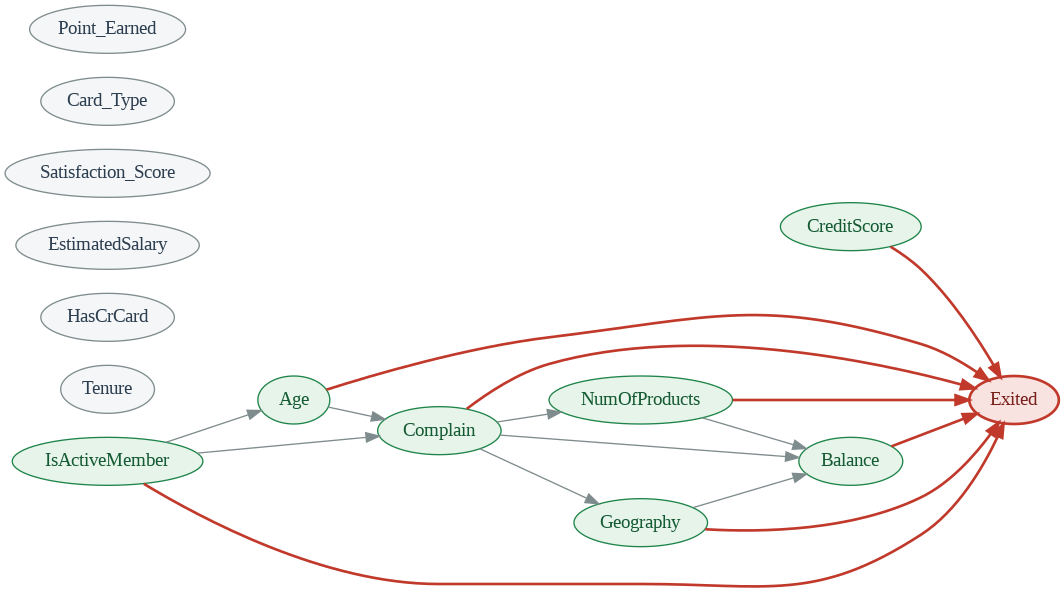

Rendered: Churn_PC_to_HC_bicd.png


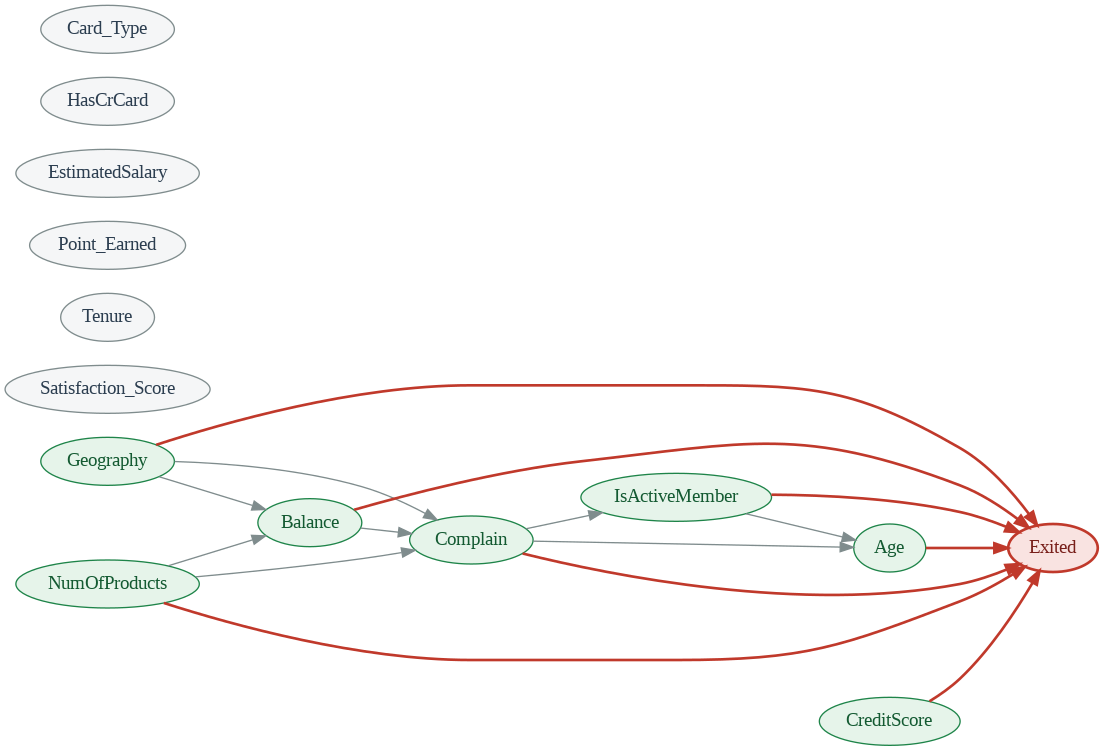

Rendered: Churn_GES_bdeu.png


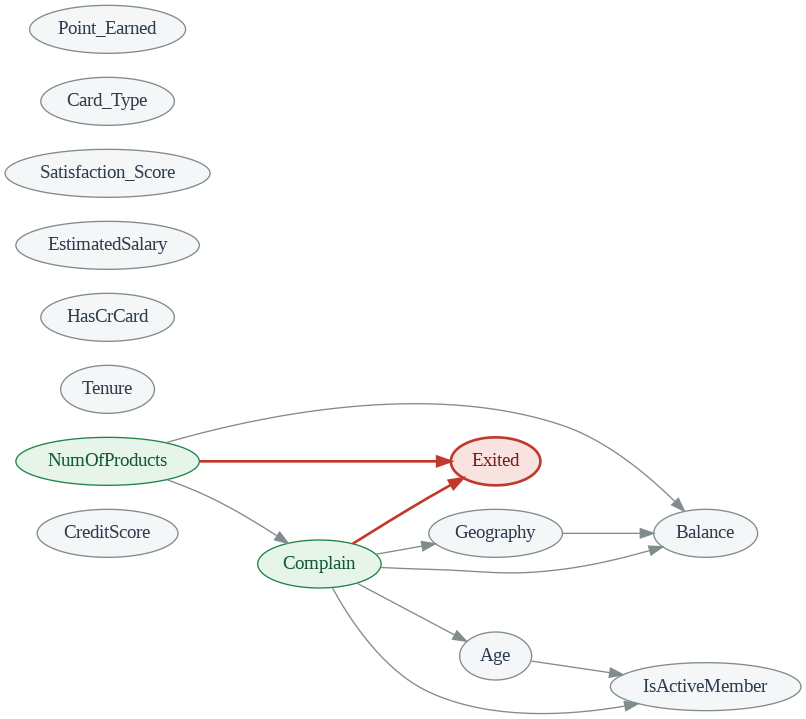

In [ ]:
# === Visualize BN DAGs (dag1, dag2, dag3) ===
# If Graphviz is not installed in Colab, this will install it and use the python 'graphviz' package.

import sys, shutil, subprocess, os
from itertools import chain

# 1) Ensure graphviz available
def ensure_graphviz():
    try:
        import graphviz  # noqa
        # also check dot binary
        if shutil.which("dot") is None:
            raise ImportError("graphviz 'dot' binary not found")
        return True
    except Exception:
        try:
            print("Installing graphviz system package + python binding...")
            # System package
            subprocess.run(["apt-get", "update"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            subprocess.run(["apt-get", "install", "-y", "graphviz"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # Python package
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "graphviz"], check=True)
            import graphviz  # noqa
            return shutil.which("dot") is not None
        except Exception as e:
            print("Graphviz install failed, will fall back to networkx drawing. Error:", e)
            return False

has_graphviz = ensure_graphviz()

# 2) Helper: get parents of Exited and style
def node_styles(dag, target="Exited"):
    nodes = list(dag.nodes())
    parents = [u for u, v in dag.edges() if v == target]
    styles = {}
    for n in nodes:
        if n == target:
            styles[n] = dict(color="#c0392b", fillcolor="#f9e3e1", fontcolor="#781f1a", shape="ellipse", style="filled,bold")
        elif n in parents:
            styles[n] = dict(color="#1e8449", fillcolor="#e6f4ea", fontcolor="#145a32", shape="ellipse", style="filled")
        else:
            styles[n] = dict(color="#7f8c8d", fillcolor="#f5f6f7", fontcolor="#2c3e50", shape="ellipse", style="filled")
    return styles, set(parents)

# 3) Render with graphviz if possible; otherwise fallback to networkx
def render_dag_gv(dag, name="DAG", target="Exited"):
    from graphviz import Digraph
    styles, parents = node_styles(dag, target)
    dot = Digraph(name=name, format="png")
    dot.attr(rankdir="LR", splines="true", overlap="false")
    # Nodes
    for n, st in styles.items():
        dot.node(n, label=n, **st)
    # Edges
    for u, v in dag.edges():
        if v == target:
            dot.edge(u, v, color="#c0392b", penwidth="2.0")
        else:
            dot.edge(u, v, color="#7f8c8d")
    outpath = dot.render(filename=name, cleanup=True)
    from IPython.display import Image, display
    print(f"Rendered: {outpath}")
    display(Image(filename=outpath))

def render_dag_nx(dag, name="DAG", target="Exited"):
    import matplotlib.pyplot as plt
    import networkx as nx
    styles, parents = node_styles(dag, target)
    G = nx.DiGraph()
    G.add_nodes_from(dag.nodes())
    G.add_edges_from(dag.edges())

    # try a nicer layout if pygraphviz/graphviz_layout available
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except Exception:
        pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(len(G.nodes())+1))

    plt.figure(figsize=(10, 6))
    # Draw nodes by groups
    other_nodes = [n for n in G.nodes() if n not in parents and n != target]
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_color="#f5f6f7", edgecolors="#7f8c8d")
    nx.draw_networkx_nodes(G, pos, nodelist=list(parents), node_color="#e6f4ea", edgecolors="#1e8449")
    nx.draw_networkx_nodes(G, pos, nodelist=[target], node_color="#f9e3e1", edgecolors="#c0392b", linewidths=2)

    # Edges (red into target)
    red_edges = [(u, v) for (u, v) in G.edges() if v == target]
    gray_edges = [(u, v) for (u, v) in G.edges() if v != target]
    nx.draw_networkx_edges(G, pos, edgelist=gray_edges, arrows=True, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, arrows=True, edge_color="#c0392b", width=2)

    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(name)
    plt.axis("off")
    plt.show()

def render_dag(dag, name="DAG", target="Exited"):
    if has_graphviz:
        return render_dag_gv(dag, name, target)
    else:
        return render_dag_nx(dag, name, target)

# 4) Render your three DAGs
render_dag(dag1, name="Churn_HC_bicd", target="Exited")
render_dag(dag2, name="Churn_PC_to_HC_bicd", target="Exited")
render_dag(dag3, name="Churn_GES_bdeu", target="Exited")


#### baga la cap

In [ ]:
# --- Bayesian Networks for Churn (pgmpy==1.0.0) ---
# Installs + full pipeline in one cell.

# 0) Install deps (Colab)
!pip -q install pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx

import io, warnings
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

# Use DiscreteBayesianNetwork (BN class changed in pgmpy 1.0.0)
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, PC, GES, ExpertKnowledge,
    BayesianEstimator, MaximumLikelihoodEstimator
)
from pgmpy.inference import VariableElimination

# ------------------ CONFIG ------------------
RSEED = 42
TARGET = "Exited"
DROP_COLS = ["RowNumber","CustomerId","Surname","Gender"]  # Gender excluded
RENAME_MAP = {"Satisfaction Score":"Satisfaction_Score",
              "Card Type":"Card_Type",
              "Point Earned":"Point_Earned"}
CONT_HINTS = ["CreditScore","Age","Tenure","Balance",
              "EstimatedSalary","Point_Earned","Satisfaction_Score"]
QBINS = 6  # finer bins for continuous vars (was 4)

# 1) Upload dataset
from google.colab import files
print("Upload your churn CSV (e.g., Customer-Churn-Records.csv)")
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
df_raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))

# 2) Prepare dataframe
df = df_raw.rename(columns=RENAME_MAP).copy()
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

assert TARGET in df.columns, f"Missing target '{TARGET}'. Columns: {df.columns.tolist()}"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# identify continuous present
cont_cols = [c for c in CONT_HINTS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

# 3) Discretize continuous vars (quantiles → ordinal bins as strings)
def discretize_quantiles(df_in: pd.DataFrame, cols: List[str], qbins: int) -> pd.DataFrame:
    if not cols:
        return df_in.copy()
    out = df_in.copy()
    est = KBinsDiscretizer(n_bins=qbins, encode="ordinal", strategy="quantile")
    X = out[cols].replace([np.inf, -np.inf], np.nan).fillna(out[cols].median())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        arr = est.fit_transform(X)
    for j, c in enumerate(cols):
        out[c] = arr[:, j].astype(int).astype(str)
    return out

df_disc = discretize_quantiles(df, cont_cols, QBINS)

# cast EVERYTHING to string states (including target) for discrete BN
for c in df_disc.columns:
    df_disc[c] = df_disc[c].astype(str)

# define global state space so unseen-in-train states are known at fit time
state_names = {c: sorted(df_disc[c].unique().tolist()) for c in df_disc.columns}

# 🔒 enforce canonical order for target states
state_names[TARGET] = ["0", "1"]

# 4) Build logical constraints via ExpertKnowledge
cols = list(df_disc.columns)

# forbid leakage: Exited -> anything
forbidden = []
for c in cols:
    if c != TARGET:
        forbidden.append((TARGET, c))

# downstream guards
def forbid_back_from(child, allowed_sources):
    for src in cols:
        if src not in allowed_sources and src != child:
            forbidden.append((child, src))

if "Point_Earned" in cols:
    forbid_back_from("Point_Earned", {"HasCrCard","Card_Type","Point_Earned"})
if "Satisfaction_Score" in cols:
    forbid_back_from("Satisfaction_Score", {"Complain","Satisfaction_Score"})

# temporal ordering: nudge features -> TARGET
temporal_order = {c: (100 if c == TARGET else 10) for c in cols}

# ensure Exited has informative parents (adjust as needed)
required_edges = set()
for p in ["Age","CreditScore","Balance","IsActiveMember","NumOfProducts","Complain","Geography"]:
    if p in cols and p != TARGET:
        required_edges.add((p, TARGET))

ek = ExpertKnowledge(
    required_edges=required_edges,
    forbidden_edges=set(forbidden),
    temporal_ordering=temporal_order
)

# dynamic max_indegree so it doesn't contradict required_edges->TARGET
required_into_target = sum(1 for u,v in required_edges if v == TARGET)
MAX_INDEGREE = max(5, required_into_target)  # was fixed 5; now at least the required count

# 5) CV evaluation helper (with Markov Blanket evidence + stable p1 extraction)
def bn_cv_metrics(dag_edges: List[Tuple[str,str]], data: pd.DataFrame, folds: int = 5) -> Dict[str,float]:
    model = DiscreteBayesianNetwork(dag_edges)
    # Markov Blanket of TARGET for stable, non-sparse evidence
    try:
        MB = model.get_markov_blanket(TARGET)
    except Exception:
        MB = [c for c in data.columns if c != TARGET]

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RSEED)
    y_all, p1_all, ll_parts = [], [], []
    fallback = 0

    for tr_idx, te_idx in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr_idx].copy(), data.iloc[te_idx].copy()
        # fit with full state space so test states are known
        try:
            model.fit(train, estimator=BayesianEstimator,
                      prior_type="BDeu", equivalent_sample_size=50,
                      state_names=state_names)
        except Exception:
            model.fit(train, estimator=MaximumLikelihoodEstimator,
                      state_names=state_names)

        ve = VariableElimination(model)
        probs = []
        for _, row in test.iterrows():
            # only MB evidence (excluding TARGET)
            ev = {k: row[k] for k in MB if k != TARGET and k in row.index}
            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                st = q.state_names[TARGET]
                # guaranteed to exist due to state_names[TARGET] = ["0","1"]
                idx1 = st.index("1")
                p1 = float(q.values[idx1])
            except Exception:
                p1 = 0.5
                fallback += 1
            probs.append(p1)

        probs = np.clip(np.array(probs, float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())

        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))

    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(np.array(y_all), np.array(p1_all))) if len(set(y_all))==2 else float("nan"),
        "inference_fallbacks": int(fallback),
    }
    return metrics

# 6) Train 3 candidates
candidates = []

# G1: Hill Climb (discrete) with BIC-d and EK
est_hc = HillClimbSearch(df_disc)
dag1 = est_hc.estimate(scoring_method="bic-d",
                       max_indegree=MAX_INDEGREE,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m1 = bn_cv_metrics(list(dag1.edges()), df_disc)
candidates.append(("HC(bic-d)", dag1, m1))

# G2: PC with EK, then refine with HC from PC start
pc = PC(df_disc)
pdag = pc.estimate(variant="stable",
                   ci_test="chi_square",
                   alpha=0.01,
                   expert_knowledge=ek,
                   enforce_expert_knowledge=True,  # PC supports hard enforcement
                   return_type="dag")
dag2 = est_hc.estimate(scoring_method="bic-d",
                       start_dag=pdag,
                       max_indegree=MAX_INDEGREE,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m2 = bn_cv_metrics(list(dag2.edges()), df_disc)
candidates.append(("PC→HC(bic-d)", dag2, m2))

# G3: GES with EK (use BDeu for diversity)
ges = GES(df_disc)
dag3 = ges.estimate(scoring_method="bdeu",
                    expert_knowledge=ek,
                    min_improvement=1e-6)
m3 = bn_cv_metrics(list(dag3.edges()), df_disc)
candidates.append(("GES(bdeu)", dag3, m3))

# 7) Rank & report
def sort_key(item):
    name, dag, met = item
    return (met["cv_logloss"], -(met["cv_auc"] if not np.isnan(met["cv_auc"]) else 0.0), -len(dag.edges()))
candidates = sorted(candidates, key=sort_key)[:3]

print("\nTop 3 graphs for churn (best first):\n")
for i,(name, dag, met) in enumerate(candidates,1):
    print(f"[{i}] {name}")
    print(f"  5-fold LogLoss: {met['cv_logloss']:.4f} | AUC: {met['cv_auc']:.4f} | Fallbacks: {met['inference_fallbacks']}")
    print(f"  Edges ({len(dag.edges())}): {sorted(list(dag.edges()))}\n")

print("Columns used:", df_disc.columns.tolist())
print("Continuous discretized:", cont_cols)
class_balance = df[TARGET].value_counts(normalize=True).to_dict()
print("Class balance (original df):", class_balance)


Upload your churn CSV (e.g., Customer-Churn-Records.csv)


Saving Customer-Churn-Records-BACKUP.csv to Customer-Churn-Records-BACKUP (1).csv


  0%|          | 0/5 [00:00<?, ?it/s]


Top 3 graphs for churn (best first):

[1] GES(bdeu)
  5-fold LogLoss: 0.0110 | AUC: 0.9985 | Fallbacks: 0
  Edges (10): [('Complain', 'Age'), ('Complain', 'Balance'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'IsActiveMember'), ('Geography', 'Balance'), ('IsActiveMember', 'Age'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Complain'), ('NumOfProducts', 'Exited')]

[2] HC(bic-d)
  5-fold LogLoss: 0.0827 | AUC: 0.9900 | Fallbacks: 0
  Edges (14): [('Age', 'Exited'), ('Balance', 'Exited'), ('Complain', 'Age'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'IsActiveMember'), ('Complain', 'NumOfProducts'), ('CreditScore', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Exited'), ('IsActiveMember', 'Age'), ('IsActiveMember', 'Exited'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Exited')]

[3] PC→HC(bic-d)
  5-fold LogLoss: 0.0827 | AUC: 0.9900 | Fallbacks: 0
  Edges (14): [('Age', 'Exited'), ('Balance', 'Exited'), ('Complain', 'Age'), (

In [ ]:
# --- Helperi de inspectie pentru DAG + CPD ---
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator

def fit_and_inspect(dag, data, state_names, target="Exited"):
    # 1) Construieste modelul si fa fit (BDeu pentru smoothing)
    model = DiscreteBayesianNetwork(list(dag.edges()))
    model.fit(
        data,
        estimator=BayesianEstimator,
        prior_type="BDeu",
        equivalent_sample_size=50,
        state_names=state_names
    )
    # 2) Liste de parinti/copii/MB pentru noduri cheie
    print("\n--- STRUCTURA ---")
    print("Noduri:", sorted(model.nodes()))
    print("Muchii:", sorted(model.edges()))
    print(f"Parintii({target}):", model.get_parents(target))
    print(f"Copiii({target}):", model.get_children(target))
    print(f"MarkovBlanket({target}):", model.get_markov_blanket(target))

    # 3) Arata CPD-urile (primele cateva, ca sa nu incarcam consola)
    print("\n--- CPD-uri (primele 5) ---")
    for i, cpd in enumerate(model.get_cpds()):
        if i >= 5:
            print("... (mai sunt CPD-uri, dar am oprit afisarea)")
            break
        print(cpd)

    # 4) O probabilitate exemplu: P(Exited=1 | MB evidenta dintr-un rand de test)
    ve = VariableElimination(model)
    row = data.sample(1, random_state=0).iloc[0]
    MB = model.get_markov_blanket(target)
    ev = {k: row[k] for k in MB if k in row.index and k != target}
    q = ve.query([target], evidence=ev, show_progress=False)
    idx1 = q.state_names[target].index("1")
    print("\nExemplu P(Exited=1 | evidenta din MB):", float(q.values[idx1]))
    return model

# Alege cei 3 candidati sortati deja (best first)
(name1, dag1, met1), (name2, dag2, met2), (name3, dag3, met3) = candidates

print(f"\n=== Inspectam {name1} ===")
model1 = fit_and_inspect(dag1, df_disc, state_names, target=TARGET)

print(f"\n=== Inspectam {name2} ===")
model2 = fit_and_inspect(dag2, df_disc, state_names, target=TARGET)

print(f"\n=== Inspectam {name3} ===")
model3 = fit_and_inspect(dag3, df_disc, state_names, target=TARGET)



=== Inspectam GES(bdeu) ===

--- STRUCTURA ---
Noduri: ['Age', 'Balance', 'Complain', 'Exited', 'Geography', 'IsActiveMember', 'NumOfProducts']
Muchii: [('Complain', 'Age'), ('Complain', 'Balance'), ('Complain', 'Exited'), ('Complain', 'Geography'), ('Complain', 'IsActiveMember'), ('Geography', 'Balance'), ('IsActiveMember', 'Age'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Complain'), ('NumOfProducts', 'Exited')]
Parintii(Exited): ['NumOfProducts', 'Complain']
Copiii(Exited): []
MarkovBlanket(Exited): ['Complain', 'NumOfProducts']

--- CPD-uri (primele 5) ---
+------------------------+---------------------+--------------------+
| Complain               | Complain(0)         | Complain(1)        |
+------------------------+---------------------+--------------------+
| Geography(Bucharest)   | 0.5275445850561751  | 0.3964878363138392 |
+------------------------+---------------------+--------------------+
| Geography(Cluj-Napoca) | 0.21279705968341478 | 0.3998711132592235 |
+----

## looking for search

In [ ]:
# --- Robust Bayesian Networks for Churn (pgmpy==1.0.0) ---
# One-cell, resilient pipeline with smart guards & fallbacks.

# 0) Install deps (Colab safe; no-op if already installed)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install pandas numpy scikit-learn pgmpy==1.0.0 tqdm networkx

import io, warnings, math, sys, traceback
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.validation import check_is_fitted

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, PC, GES, ExpertKnowledge,
    BayesianEstimator, MaximumLikelihoodEstimator
)
from pgmpy.inference import VariableElimination

RSEED = 42
np.random.seed(RSEED)

# ------------------ CONFIG (user-facing) ------------------
TARGET = "Exited"          # daca nu exista, se va incerca autodetect
DROP_COLS = ["RowNumber","CustomerId","Surname","Gender"]  # siguranta: le scoatem daca apar
RENAME_MAP = {"Satisfaction Score":"Satisfaction_Score",
              "Card Type":"Card_Type",
              "Point Earned":"Point_Earned"}

# hint-uri pt continue (daca lipsesc, codul continua oricum)
CONT_HINTS = ["CreditScore","Age","Tenure","Balance",
              "EstimatedSalary","Point_Earned","Satisfaction_Score"]

# discretizare preferata (quantile), dar se va alege dinamic daca distributiile sunt skew
QBINS_PRIMARY = 6
QBINS_FALLBACK = 4

# expert edges propuse: doar daca variabilele exista in df
REQ_PARENTS_FOR_TARGET = ["Age","CreditScore","Balance","IsActiveMember","NumOfProducts","Complain","Geography"]

# ------------------ UTILS ------------------
def log(msg: str):
    print(f"[BN] {msg}")

def safe_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors="coerce")

def is_binary_like(s: pd.Series) -> bool:
    vals = pd.unique(s.dropna())
    if len(vals) <= 1:
        return False
    # incercam sa vedem daca poate fi mapata in {0,1}
    try:
        tmp = pd.to_numeric(vals, errors="coerce")
        ok = set(pd.Series(tmp).dropna().astype(int).astype(str)).issubset({"0","1"})
        return ok
    except Exception:
        return False

def choose_discretizer(X: pd.DataFrame, qbins: int) -> KBinsDiscretizer:
    # daca variabilele sunt foarte skewed, kmeans ajuta; altfel quantile
    skew = X.skew(numeric_only=True).abs().fillna(0.0)
    if (skew > 1.0).mean() > 0.4:
        strategy = "kmeans"
    else:
        strategy = "quantile"
    return KBinsDiscretizer(n_bins=qbins, encode="ordinal", strategy=strategy)

def discretize_adaptive(df_in: pd.DataFrame, cols: List[str], qbins: int, qbins_fallback: int) -> pd.DataFrame:
    if not cols:
        return df_in.copy()
    out = df_in.copy()
    X = out[cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    # mediana pe coloana, dar daca e toata NaN -> 0
    fill_vals = {}
    for c in cols:
        med = X[c].median()
        fill_vals[c] = 0.0 if pd.isna(med) else med
    X = X.fillna(fill_vals)
    # primary
    try:
        est = choose_discretizer(X, qbins)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            arr = est.fit_transform(X)
        for j, c in enumerate(cols):
            out[c] = arr[:, j].astype(int).astype(str)
        log(f"Discretizare: strategy='{est.strategy}', bins={qbins}")
        return out
    except Exception as e:
        log(f"Discretizare primara a esuat ({e}). Incerc fallback bins={qbins_fallback} cu 'quantile'.")
        try:
            est = KBinsDiscretizer(n_bins=qbins_fallback, encode="ordinal", strategy="quantile")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                arr = est.fit_transform(X)
            for j, c in enumerate(cols):
                out[c] = arr[:, j].astype(int).astype(str)
            log(f"Discretizare fallback aplicata: 'quantile', bins={qbins_fallback}")
            return out
        except Exception as e2:
            log(f"Discretizare fallback a esuat ({e2}). Pastrez numeric->string brut.")
            for c in cols:
                out[c] = out[c].fillna(fill_vals[c]).astype(float).round(6).astype(str)
            return out

def build_expert_knowledge(cols: List[str], target: str) -> ExpertKnowledge:
    forbidden = []
    # interzicem scurgerea din target spre feature
    for c in cols:
        if c != target:
            forbidden.append((target, c))
    # reguli de downstream (siguranta, se aplica doar daca campurile exista)
    if "Point_Earned" in cols:
        allowed = {"HasCrCard","Card_Type","Point_Earned"}
        for src in cols:
            if src not in allowed and src != "Point_Earned":
                forbidden.append(("Point_Earned", src))
    if "Satisfaction_Score" in cols:
        allowed = {"Complain","Satisfaction_Score"}
        for src in cols:
            if src not in allowed and src != "Satisfaction_Score":
                forbidden.append(("Satisfaction_Score", src))

    temporal_order = {c: (100 if c == target else 10) for c in cols}

    required_edges = set()
    for p in REQ_PARENTS_FOR_TARGET:
        if p in cols and p != target:
            required_edges.add((p, target))

    ek = ExpertKnowledge(
        required_edges=required_edges,
        forbidden_edges=set(forbidden),
        temporal_ordering=temporal_order
    )
    return ek

def compute_markov_blanket_or_all(model: DiscreteBayesianNetwork, target: str, cols: List[str]) -> List[str]:
    try:
        MB = model.get_markov_blanket(target)
        MB = [c for c in MB if c != target and c in cols]
        if len(MB) == 0:
            return [c for c in cols if c != target]
        return MB
    except Exception:
        return [c for c in cols if c != target]

def fit_model_with_priors(model: DiscreteBayesianNetwork,
                          train: pd.DataFrame,
                          state_names: Dict[str, List[str]],
                          eq_size: int = 50):
    # incercam Bayesian(BDeu), altfel MLE
    try:
        model.fit(train, estimator=BayesianEstimator,
                  prior_type="BDeu", equivalent_sample_size=eq_size,
                  state_names=state_names)
    except Exception:
        model.fit(train, estimator=MaximumLikelihoodEstimator,
                  state_names=state_names)

def extract_p1(q, target: str) -> float:
    st = q.state_names[target]
    # garantam "0","1" in state_names[TARGET]
    idx1 = st.index("1")
    return float(q.values[idx1])

# ------------------ LOAD DATA ------------------
if IN_COLAB:
    from google.colab import files
    log("Upload your CSV (e.g., Customer-Churn-Records.csv)")
    uploaded = files.upload()
    csv_name = list(uploaded.keys())[0]
    df_raw = pd.read_csv(io.BytesIO(uploaded[csv_name]))
else:
    # In afara Colab: modifica PATH dupa caz.
    # Exemplu:
    # csv_name = "Customer-Churn-Records.csv"
    # df_raw = pd.read_csv(csv_name)
    raise SystemExit("[BN] Ruleaza in Colab sau adapteaza sectiunea de citire CSV pentru mediul tau.")

log(f"Loaded shape: {df_raw.shape}")

# ------------------ PREP ------------------
df = df_raw.rename(columns=RENAME_MAP).copy()

# drop coloane „sigur ne-informative”
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# autodetect TARGET daca lipseste
if TARGET not in df.columns:
    # cautam o coloana binara plauzibila
    candidates = []
    for c in df.columns:
        s = df[c]
        if s.dtype == object:
            su = set(s.dropna().astype(str).str.strip().str.lower().unique())
            if su.issubset({"0","1","true","false","yes","no"}):
                candidates.append(c)
        else:
            if is_binary_like(s):
                candidates.append(c)
    if len(candidates) >= 1:
        TARGET = candidates[0]
        log(f"TARGET absent. Autodetected TARGET='{TARGET}'.")
    else:
        raise AssertionError("Nu am gasit TARGET si nu pot autodetecta o coloana binara plauzibila.")

# normalizam TARGET in {0,1} int apoi in string
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
if df[TARGET].dropna().nunique() > 2:
    # daca e multi-clasa numeric, il binarizam dupa mediana (fallback generic)
    med = df[TARGET].median()
    df[TARGET] = (df[TARGET] > med).astype(int)
else:
    # mapam true/false/yes/no daca apar
    df[TARGET] = df[TARGET].fillna(0)
    df[TARGET] = (df[TARGET] > 0).astype(int)

# strip pentru obiecte
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# detectam continue prezente
cont_cols = [c for c in CONT_HINTS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
# plus numeric „surpriza” (dar excludem targetul)
extra_numeric = [c for c in df.columns if c != TARGET and pd.api.types.is_numeric_dtype(df[c]) and c not in cont_cols]
for c in extra_numeric:
    cont_cols.append(c)

cont_cols = sorted(set(cont_cols))

# discretizare adaptiva
df_disc = discretize_adaptive(df, cont_cols, QBINS_PRIMARY, QBINS_FALLBACK)

# totul in string (inclusiv TARGET)
df_disc[TARGET] = df[TARGET].astype(int).astype(str)
for c in df_disc.columns:
    df_disc[c] = df_disc[c].astype(str)

# state space complet + fortam ordinea la target
state_names = {c: sorted(pd.unique(df_disc[c].astype(str))) for c in df_disc.columns}
state_names[TARGET] = ["0", "1"]

# ------------------ EXPERT KNOWLEDGE ------------------
cols = list(df_disc.columns)
ek = build_expert_knowledge(cols, TARGET)

# max_indegree dinamic: sa nu contrazicem required_edges
required_into_target = sum(1 for (u,v) in ek.required_edges if v == TARGET)
MAX_INDEGREE = max(5, required_into_target)

# ------------------ CV METRICS (robust) ------------------
def bn_cv_metrics(dag_edges: List[Tuple[str,str]], data: pd.DataFrame, folds: int = 5) -> Dict[str, float]:
    model = DiscreteBayesianNetwork(dag_edges)
    cols_local = list(data.columns)
    MB = compute_markov_blanket_or_all(model, TARGET, cols_local)

    skf = StratifiedKFold(n_splits=min(folds, data[TARGET].nunique() and 5 or 3),
                          shuffle=True, random_state=RSEED)

    y_all, p1_all, ll_parts = [], [], []
    fallback = 0

    for tr_idx, te_idx in skf.split(data, data[TARGET].astype(int)):
        train, test = data.iloc[tr_idx].copy(), data.iloc[te_idx].copy()
        # fit cu prior BDeu; fallback MLE
        fit_model_with_priors(model, train, state_names, eq_size=50)

        ve = VariableElimination(model)
        probs = []

        for _, row in test.iterrows():
            # evidenta doar pe MB, filtrand NaN/valori lipsa
            ev = {}
            for k in MB:
                val = row.get(k, None)
                if pd.isna(val):
                    continue
                val = str(val)
                # daca valoarea nu este in state_names, o sarim (evitam KeyError)
                if k in state_names and val not in state_names[k]:
                    continue
                ev[k] = val

            try:
                q = ve.query(variables=[TARGET], evidence=ev, show_progress=False)
                p1 = extract_p1(q, TARGET)
                if not np.isfinite(p1):
                    raise ValueError("p1 not finite")
            except Exception:
                p1 = 0.5
                fallback += 1
            probs.append(p1)

        probs = np.clip(np.asarray(probs, dtype=float), 1e-6, 1-1e-6)
        y = test[TARGET].astype(int).to_numpy()
        y_all.extend(y.tolist()); p1_all.extend(probs.tolist())

        try:
            ll_parts.append(log_loss(y, np.vstack([1-probs, probs]).T, labels=[0,1]))
        except Exception:
            ll_parts.append(log_loss(y, probs, labels=[0,1]))

    metrics = {
        "cv_logloss": float(np.mean(ll_parts)),
        "cv_auc": float(roc_auc_score(np.array(y_all), np.array(p1_all))) if len(set(y_all))==2 else float("nan"),
        "inference_fallbacks": int(fallback),
    }
    return metrics

# ------------------ STRUCTURE LEARNING (3 candidates) ------------------
candidates = []

# G1: HC (bic-d)
est_hc = HillClimbSearch(df_disc)
dag1 = est_hc.estimate(scoring_method="bic-d",
                       max_indegree=MAX_INDEGREE,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m1 = bn_cv_metrics(list(dag1.edges()), df_disc)
candidates.append(("HC(bic-d)", dag1, m1))

# G2: PC -> HC
pc = PC(df_disc)
pdag = pc.estimate(variant="stable",
                   ci_test="chi_square",
                   alpha=0.01,
                   expert_knowledge=ek,
                   enforce_expert_knowledge=True,
                   return_type="dag")
dag2 = est_hc.estimate(scoring_method="bic-d",
                       start_dag=pdag,
                       max_indegree=MAX_INDEGREE,
                       expert_knowledge=ek,
                       tabu_length=100,
                       max_iter=1_000_000,
                       show_progress=False)
m2 = bn_cv_metrics(list(dag2.edges()), df_disc)
candidates.append(("PC→HC(bic-d)", dag2, m2))

# G3: GES (bdeu)
ges = GES(df_disc)
dag3 = ges.estimate(scoring_method="bdeu",
                    expert_knowledge=ek,
                    min_improvement=1e-6)
m3 = bn_cv_metrics(list(dag3.edges()), df_disc)
candidates.append(("GES(bdeu)", dag3, m3))

# ------------------ RANK & REPORT ------------------
def sort_key(item):
    name, dag, met = item
    return (met["cv_logloss"], -(met["cv_auc"] if not np.isnan(met["cv_auc"]) else 0.0), -len(dag.edges()))

candidates = sorted(candidates, key=sort_key)[:3]

print("\nTop 3 graphs for churn (best first):\n")
for i,(name, dag, met) in enumerate(candidates,1):
    print(f"[{i}] {name}")
    print(f"  5-fold LogLoss: {met['cv_logloss']:.4f} | AUC: {met['cv_auc']:.4f} | Fallbacks: {met['inference_fallbacks']}")
    print(f"  Edges ({len(dag.edges())}): {sorted(list(dag.edges()))}\n")

print("Columns used:", df_disc.columns.tolist())
print("Continuous discretized:", cont_cols)
class_balance = df[TARGET].value_counts(normalize=True).to_dict()
print("Class balance (original df):", class_balance)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 35.6 MB/s eta 0:00:00
[BN] Upload your CSV (e.g., Customer-Churn-Records.csv)


Saving Customer-Churn-Records-BACKUP.csv to Customer-Churn-Records-BACKUP.csv
[BN] Loaded shape: (10000, 18)
[BN] Discretizare: strategy='quantile', bins=6


  0%|          | 0/5 [00:00<?, ?it/s]


Top 3 graphs for churn (best first):

[1] GES(bdeu)
  5-fold LogLoss: 0.4237 | AUC: 0.7710 | Fallbacks: 0
  Edges (6): [('Age', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Exited'), ('NumOfProducts', 'Age'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Exited')]

[2] HC(bic-d)
  5-fold LogLoss: 0.5165 | AUC: 0.7355 | Fallbacks: 0
  Edges (10): [('Age', 'Exited'), ('Age', 'NumOfProducts'), ('Balance', 'Exited'), ('Complain', 'Exited'), ('CreditScore', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Exited'), ('IsActiveMember', 'Exited'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Exited')]

[3] PC→HC(bic-d)
  5-fold LogLoss: 0.5165 | AUC: 0.7355 | Fallbacks: 0
  Edges (10): [('Age', 'Exited'), ('Age', 'NumOfProducts'), ('Balance', 'Exited'), ('Complain', 'Exited'), ('CreditScore', 'Exited'), ('Geography', 'Balance'), ('Geography', 'Exited'), ('IsActiveMember', 'Exited'), ('NumOfProducts', 'Balance'), ('NumOfProducts', 'Exited')]

Columns used: ['CreditScore', 'Geo